<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Iteration4_UncertaintyRangeExp_LoanPredict_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise에 의한 Drift 유도 Simulation 실험

# 1 구글 드라이브 연결

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 함수 선언



In [131]:
a = np.array([[2,2,5], [3,4,9]])
print(np.std(a))
print(np.std(a, axis=0))
print(np.std(a, axis=1))


2.4094720491334933
[0.5 1.  2. ]
[1.41421356 2.62466929]


In [144]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp,exp_model_param):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(df_state,x_inf_d,exp_model_param):
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])
    #print(permutaion_sigma)
    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data(exp_model_param,x_train,train_gt ):
    temp_X = []
    temp_Y = []
    mean = np.mean(x_train,axis=0)
    std = np.std(x_train,axis=0)
    df_state = pd.DataFrame({"mean":mean,"std":std})

    print('random_sigma_add, mean:',mean)
    print('random_sigma_add, std:',std)

    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train,exp_model_param)
        temp_X.append(random_sigma_add(df_state,x_train[sample_idx],exp_model_param))
        temp_Y.append(train_gt[sample_idx])
    return np.asarray(temp_X), np.asarray(temp_Y)

In [133]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def D3(reference, inference, model):
    y1 = np.zeros(reference.shape[0]).reshape(-1, 1)
    y2 = np.ones(inference.shape[0]).reshape(-1, 1)
    X = np.vstack((reference, inference))
    y = np.vstack((y1, y2))
    lr = LogisticRegression(solver="lbfgs", random_state=0, max_iter=5000).fit(X, y.ravel())
    return roc_auc_score(y, lr.predict_proba(X)[:, 1])

from scipy.stats import ks_2samp, entropy
def uncertainty(reference, inference, model):
    entropy_ref = entropy(model.predict_proba(reference), axis = -1)
    entropy_inf = entropy(model.predict_proba(inference), axis = -1)
    d, p = ks_2samp(entropy_ref, entropy_inf)
    return d

from scipy.linalg import sqrtm
def FID(reference, inference, model):
    act_ref, act_inf = [], []

    #print('FID reference:',reference.shape)
    #print('FID inference:',inference.shape)

    for i in range(reference.shape[0]):
        refr, infr = reference[i, :], inference[i, :]
        vmin, vmax = min(refr.min(), infr.min()), max(refr.max(), infr.max())
        bins = int(1+3.322*np.log10(max(len(refr), len(infr))))
        refh, _ = np.histogram(refr, range=(vmin, vmax), bins=bins)
        infh, _ = np.histogram(infr, range=(vmin, vmax), bins=bins)
        act_ref.append(refh)
        act_inf.append(infh)

    act_ref = np.array(act_ref)
    act_inf = np.array(act_inf)
    mu1, sigma1 = np.mean(act_ref, axis=0), np.cov(act_ref, rowvar=False)
    mu2, sigma2 = np.mean(act_inf, axis=0), np.cov(act_inf, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    mat_dot = sigma1.dot(sigma2)
    covmean = sqrtm(mat_dot)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


In [134]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

#4 실험

## 준비

In [145]:
# 실험 모델 환경 설정
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,r2_score
def accuracy(model, X, y):
    return accuracy_score(model.predict(X), y)*100

def f1(model, X, y):
    return f1_score(model.predict(X), y) *100


In [136]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [143]:
main_figsize = (15,3)

def MI_Drift_F1(model, X,y,train_size,test_size,bucket_size=200):

    MIS = {}
    DRF = {}
    F1S = []
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    step_size = int((X.shape[0]-(train_size+test_size))/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tmp_x = X[bk*bucket_size:bk*bucket_size+bucket_size]
        tmp_y = y[bk*bucket_size:bk*bucket_size+bucket_size]
        mi_scores = make_mi_scores(tmp_x,tmp_y , discrete_features="auto")
        ks = __ks_drift(X[0:train_size].values,
                        X[bk*bucket_size+(train_size+test_size):bk*bucket_size+bucket_size+(train_size+test_size)].values)
        #predicted_y = model.predict(tmp_x)
        f1_ = f1(model,tmp_x,tmp_y)
        F1S.append(f1_)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[columns].values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[columns].values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(F1S,linewidth=1,label='f1 score')
    plt.ylabel('F1 Score')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1)
    plt.show()

In [167]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

class DriftDetector():
    def __init__(self, threshold,n=3):

        self.threshold = threshold
        self.n = n
        self.current_count = 0
        self.time = 0
        self.value = 0.0

    def detect(self, drift_value):
        if self.current_count >= self.n:
            return True

        if self.threshold < drift_value:
            self.current_count = self.current_count +1
        else:
            self.current_count = 0

        self.value = drift_value
        if self.current_count >= self.n:
            return True

        self.time = self.time + 1
        return False

def experiment(X,y,train_size,test_size,threshold=85):

    seed_everything()

    # Normalize
    scaler_c1 = StandardScaler()
    scaler_c1.fit(X[0:train_size])
    X = pd.DataFrame(scaler_c1.transform(X), columns=columns)
    # Model train...
    model = RandomForestClassifier(max_depth=6).fit(X[0:train_size], y[0:train_size])
    # Dataset 구성
    x_train = X.values[:train_size]
    y_train_gt = y[:train_size].reshape(-1,1)

    mi_scores = make_mi_scores(pd.DataFrame(x_train,columns=columns), y[:train_size], discrete_features="auto")
    max_mi = np.max(mi_scores)

    x_test = X[test_size:train_size+test_size].values
    y_test_gt = y[test_size:train_size+test_size].reshape(-1,1)

    x_live = X[test_size:].values
    y_live_gt = y[test_size:].reshape(-1,1)

    print('Structure of dataset, x_train:',x_train.shape, 'x_test:',x_test.shape, 'x_live:',x_live.shape)

    # 기타 parameter 구성
    ######################################### sigma 를 수정
    exp_model_param = {
        "exp_num":[400],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":[accuracy, f1]
        }
    '''
    if max_mi < 0.01:
        exp_model_param['sigma'] = [0,1/max_mi]
        print(exp_model_param['sigma'])
    '''

    # Testset의 Metric 측정
    test_score = []
    # 후미 test_size 개수만 대상.
    print(f'uncertainty: (x_train={x_train.shape}, x_test={x_test.shape})')
    test_unc = uncertainty(x_train,x_test,model)
    metric_name = []
    for i, metric in enumerate(exp_model_param['metric']):
        metric_name.append(metric.__name__)
        test_score.append(metric(model,x_test,y_test_gt))

    print(f'Max MI for Trainset {max_mi:.5f}, Testset metric {metric_name}:{test_score}, Testset uncertainty : {test_unc:.5f}')

    # Noise 주입!
    exp_X_list, exp_y_list = add_drirft_data(exp_model_param,x_test,y_test_gt)

    print('Noise set : ',exp_X_list.shape)
    result_d_value = []
    result_score = []
    for exp_X,exp_y in zip(tqdm(exp_X_list),exp_y_list):
        # 설정한 Metric을 기반으로 Score 계산
        exp_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            exp_score.append(metric(model,exp_X, exp_y))
        result_score.append(exp_score)
        # Uncertainty 계산
        result_d_value.append(uncertainty(x_train, exp_X,model))

    result_d_value = np.asarray(result_d_value)
    result_score = np.asarray(result_score)

    exp_lr_model = LinearRegression().fit(result_d_value.reshape(-1, 1),result_score[:,0])
    '''
    # Upper, Lower LinearRegression 학습...
    exp_df = pd.DataFrame({'DV':result_d_value,'SC':result_score[:,0]})
    exp_df = exp_df.sort_values(by=['DV'], ascending=True)

    width = 20
    exp_df_set = [exp_df[i:i+width] for i in range(0,exp_df.shape[0],width)]

    # 여기서, upper와 lower 를 나눈다.
    exp_upper = []
    exp_lower = []

    for df_set in exp_df_set:
        mx_set = df_set[df_set['SC'] == np.max(df_set['SC'])]
        mn_set = df_set[df_set['SC'] == np.min(df_set['SC'])]
        exp_upper.append([mx_set['DV'].values[0],mx_set['SC'].values[0]])
        exp_lower.append([mn_set['DV'].values[0],mn_set['SC'].values[0]])

    exp_upper = np.asarray(exp_upper)
    exp_lower = np.asarray(exp_lower)
    #print('exp_upper,',exp_upper.shape)
    #print('exp_lower,',exp_lower.shape)

    exp_up_model = LinearRegression().fit(exp_upper[:,0].reshape(-1, 1),exp_upper[:,1])
    exp_lw_model = LinearRegression().fit(exp_lower[:,0].reshape(-1, 1),exp_lower[:,1])
    #exp_in_model = LinearRegression().fit(result_score[:,0].reshape(-1, 1),result_d_value)


    ############################# 보정 처리 ############################
    # 실험 LinearRegression의 Y 절편 (drift가 없을 때의 metric) 을 testset의 metric에 맞춤
    # 실험 drift(uncen)의 최소값을 testset의 drift(uncen)에 맞춤
    delta = test_score[0] - exp_lw_model.intercept_
    print(f'Y Adjustment:{delta:.5f}')

    delta_x = np.min(result_d_value) - test_unc
    print(f'X Adjustment:{delta_x:.5f}')
    ######################################################################
    '''
    # real data의 score vs drift 취득
    live_set = []
    live_set_y = []
    truncate_count = 0
    bucket_size=(train_size,test_size)
    for i in range(int(x_live.shape[0]/bucket_size[1])):
        xl = x_live[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        yl = y_live_gt[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]]
        if len(xl) ==  train_size:
            live_set.append(xl)
            live_set_y.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {x_live.shape}')

    live_set = np.asarray(live_set)
    live_set_y = np.asarray(live_set_y)

    real_scores = []
    real_d_value = []
    print('Live set : ',live_set.shape)
    for live_unit,live_unit_y in zip(tqdm(live_set), live_set_y):#tqdm(zip(live_set,live_set_y)):
        # 설정한 Metric을 기반으로 Score 계산
        real_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            real_score.append(metric(model,live_unit,live_unit_y))
        real_scores.append(real_score)
        # Uncertainty 계산
        real_d_value.append(uncertainty(x_train,live_unit,model))

    real_d_value = np.asarray(real_d_value)
    real_scores = np.asarray(real_scores)

    real_lr_model = LinearRegression().fit(real_d_value.reshape(-1, 1),real_scores[:,0])
    #real_in_model = LinearRegression().fit(real_scores[:,0].reshape(-1, 1),real_d_value)

    dd = np.concatenate((result_d_value,real_d_value),axis=0)

    d_min = np.min(dd)
    d_max = np.max(dd)
    xsx = np.arange(d_min-(d_max-d_min)/100,d_max,(d_max-d_min)/100)

    #plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    #plt.show()

    plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
    plt.plot(xsx,exp_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_line')
    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    exp_d_value = (threshold - exp_lr_model.intercept_) / exp_lr_model.coef_[0]
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')
    '''
    print("################ 보정 처리 ###############")

    plt.scatter(result_d_value-delta_x,result_score[:,0]+delta,marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')

    plt.plot(xsx-delta_x,exp_lr_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_line')

    plt.plot(xsx-delta_x,exp_up_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_up_line')
    plt.plot(xsx-delta_x,exp_lw_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_ - delta) / exp_lr_model.coef_[0] - delta_x
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'expected_uncertainty @ threshold {threshold} : {exp_d_value:.5f}')
    print(f'    real_uncertainty @ threshold {threshold} : {rel_d_value:.5f}')
    print(f'threshold error : {np.abs(rel_d_value-exp_d_value):.5f}')
    '''
    plt.figure(figsize=(15,3))
    predict_scores = exp_lr_model.predict(real_d_value.reshape(-1,1))
    plt.plot(predict_scores,linewidth=1,label='exp score')
    # 보정한 결과로 R2 측정
    plt.plot(real_scores[:,0],linewidth=2,label='real score')
    #predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))
    #plt.plot(predict_scores,linewidth=1,linestyle = ':', label='exp score')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    print(f'r2 of expected metric vs real metric :{r2_score(real_scores[:,0],predict_scores):.5f}')


    plt.figure(figsize=(15,3))
    plt.plot(real_d_value,linewidth=1,label='uncen value')
    #plt.axhline(y = test_unc, color = 'b', linestyle = ':',label='test_uncen')
    #th1 = test_unc + test_unc * 0.1
    #th2 = test_unc + test_unc * 0.2
    th3 = test_unc + test_unc * 0.3
    #plt.axhline(y = th1, linestyle = ':',label='test_uncen(10%)')
    #plt.axhline(y = th2, linestyle = ':',label='test_uncen(20%)')
    plt.axhline(y = exp_d_value, linestyle = ':',color = 'r', label='expected uncertainty')

    # test_uncen(30%)을 threshold로 설정, 3회 연속 over일 경우, detect
    ddd = DriftDetector(exp_d_value,2)
    dt = [ddd.detect(v) for v in real_d_value]
    if np.sum(dt) > 0:
        plt.axvline(x = ddd.time, color='r', linestyle = ':',label='detect')
        print(f'Detect at {ddd.time} time, uncertainty {ddd.value:.5f} metric {real_scores[ddd.time,0]:.5f}')
    else:
        print('Detect fail!!')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()



## Case #1 MI의 감소, Drift의 증가

In [168]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(0,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.24430, Testset metric ['accuracy', 'f1']:[93.27777777777779, 93.30381848367459], Testset uncertainty : 0.02222
random_sigma_add, mean: [ 0.01725187 -0.00799523 -0.00328056 -0.00155096 -0.00219686]
random_sigma_add, std: [0.99532794 0.98750031 0.99850919 1.01156211 1.01427604]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:49<00:00,  8.13it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:23<00:00,  8.14it/s]


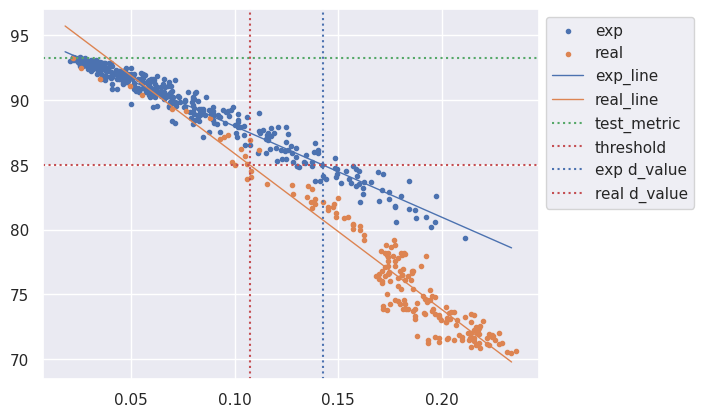

expected_uncertainty @ threshold 85 : 0.14243
    real_uncertainty @ threshold 85 : 0.10727
threshold error : 0.03516


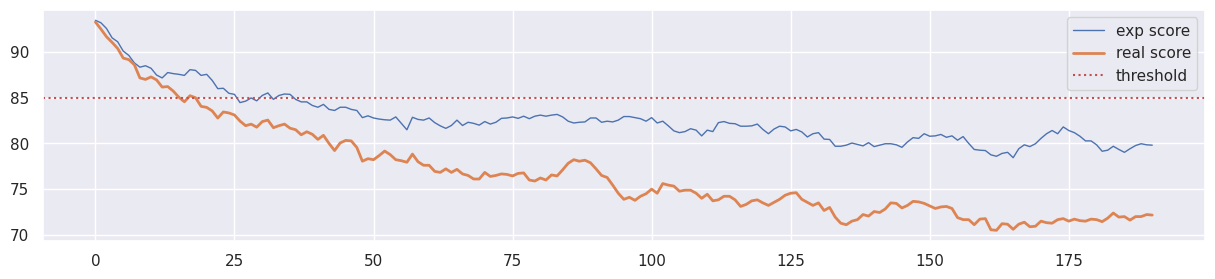

r2 of expected metric vs real metric :-0.56090
Detect at 27 time, uncertainty 0.14778 metric 81.94444


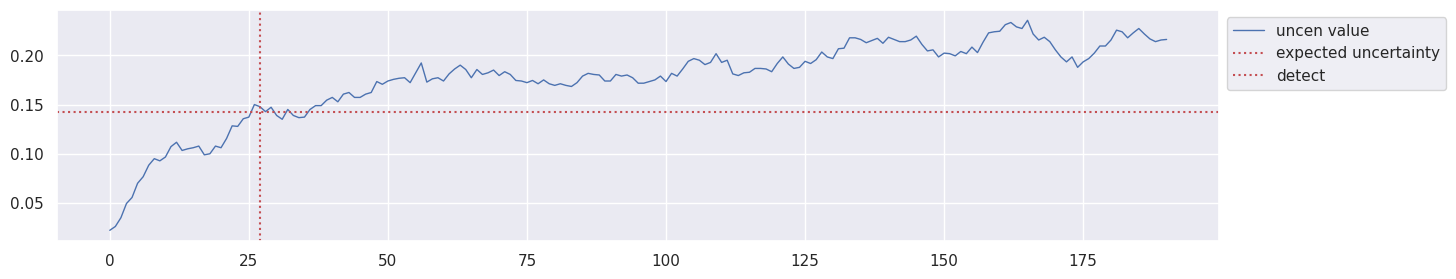

In [169]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #2 MI의 증감(상대적), Drift의 고정

In [170]:

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)


m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

5
21426
z0    0.123425
x0    0.079212
x1    0.032962
x2    0.008752
x3    0.007456
Name: MI Scores, dtype: float64


In [171]:
X = X1
y = np.asarray(y1)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.31550, Testset metric ['accuracy', 'f1']:[94.38888888888889, 95.22909777987718], Testset uncertainty : 0.00722
random_sigma_add, mean: [-0.01720884  0.0204692  -0.00586527 -0.00011487  0.00304705]
random_sigma_add, std: [1.00389506 1.0000747  0.99004917 0.9999128  1.01718532]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:44<00:00,  8.89it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:21<00:00,  8.94it/s]


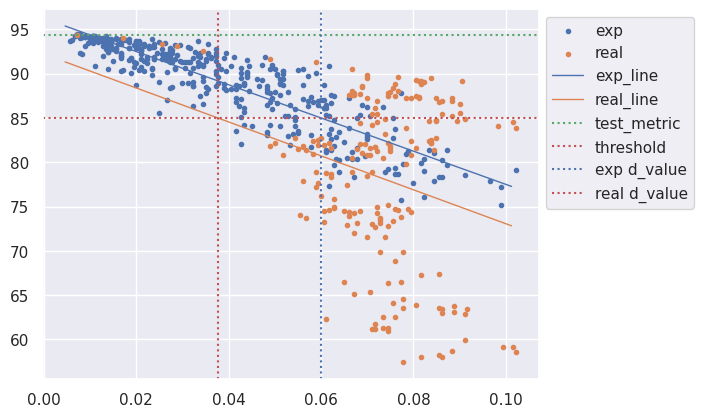

expected_uncertainty @ threshold 85 : 0.05999
    real_uncertainty @ threshold 85 : 0.03765
threshold error : 0.02234


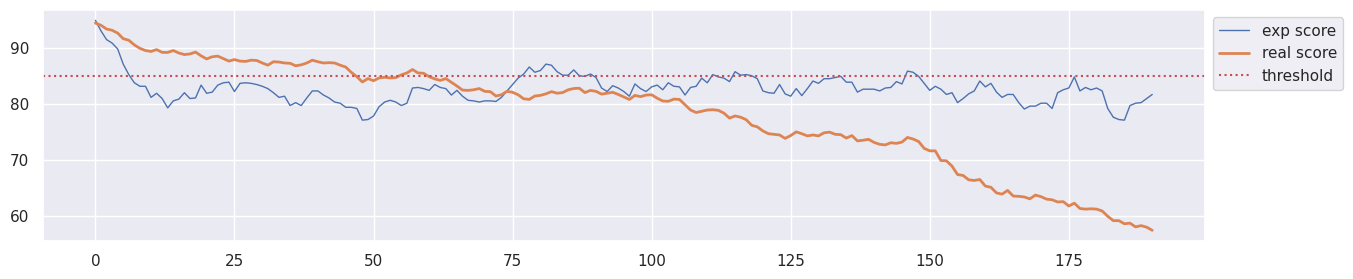

r2 of expected metric vs real metric :-0.13619
Detect at 8 time, uncertainty 0.07000 metric 89.88889


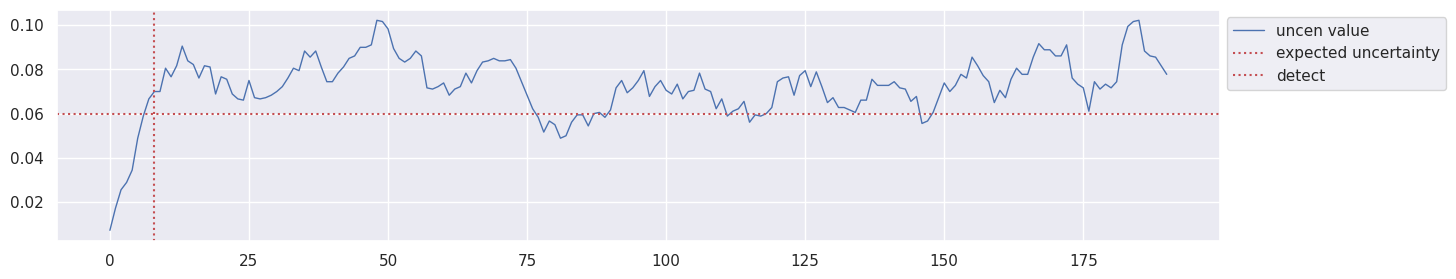

In [172]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,threshold=85)

## Case #3 MI의 증감(상대적), Drift의 증가

In [173]:

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

7.2404412558678075
z0    0.269203
x0    0.077964
x1    0.028502
x2    0.012955
x3    0.001920
Name: MI Scores, dtype: float64


In [174]:
X = X2
y = np.asarray(y2)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.21928, Testset metric ['accuracy', 'f1']:[97.94444444444444, 94.56681350954479], Testset uncertainty : 0.01611
random_sigma_add, mean: [-0.00251425 -0.01370523 -0.00951141 -0.00398562  0.08818106]
random_sigma_add, std: [0.98658414 0.99804769 0.99779312 1.00481907 1.07328749]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:22<00:00,  8.51it/s]


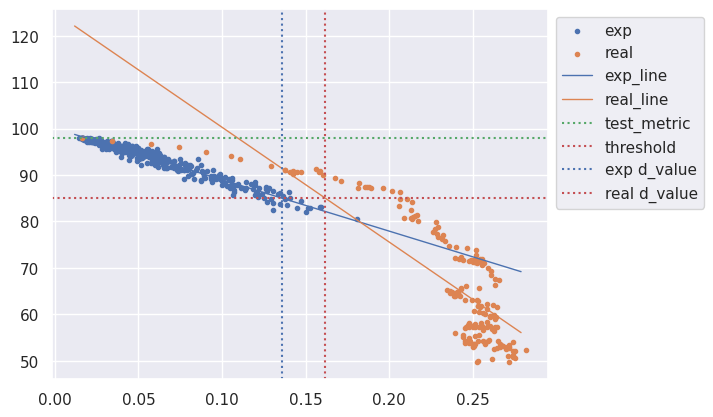

expected_uncertainty @ threshold 85 : 0.13612
    real_uncertainty @ threshold 85 : 0.16192
threshold error : 0.02580


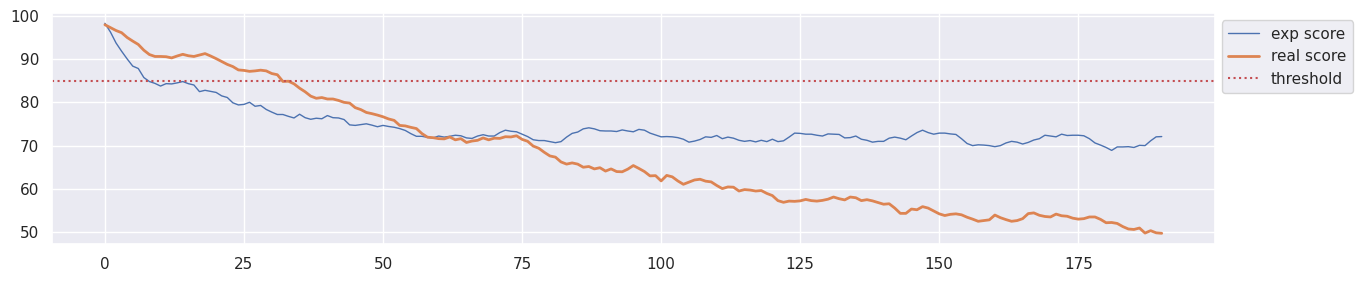

r2 of expected metric vs real metric :0.24785
Detect at 9 time, uncertainty 0.14167 metric 90.61111


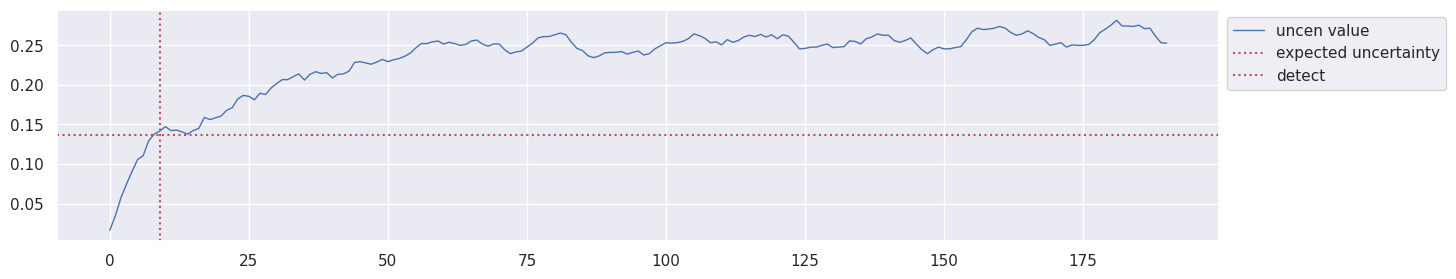

In [175]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #4 MI의 고정, Drift의 증가

In [176]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)

columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [177]:
X = X3
y = np.asarray(y3)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.33612, Testset metric ['accuracy', 'f1']:[95.77777777777777, 95.84699453551913], Testset uncertainty : 0.01222
random_sigma_add, mean: [ 0.01725187 -0.00799523 -0.00328056 -0.00155096  0.02217939]
random_sigma_add, std: [0.99532794 0.98750031 0.99850919 1.01156211 0.9933982 ]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:48<00:00,  8.24it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:22<00:00,  8.54it/s]


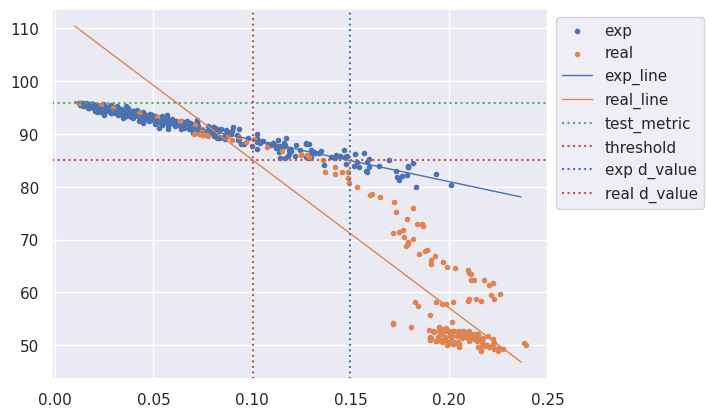

expected_uncertainty @ threshold 85 : 0.14952
    real_uncertainty @ threshold 85 : 0.10062
threshold error : 0.04890


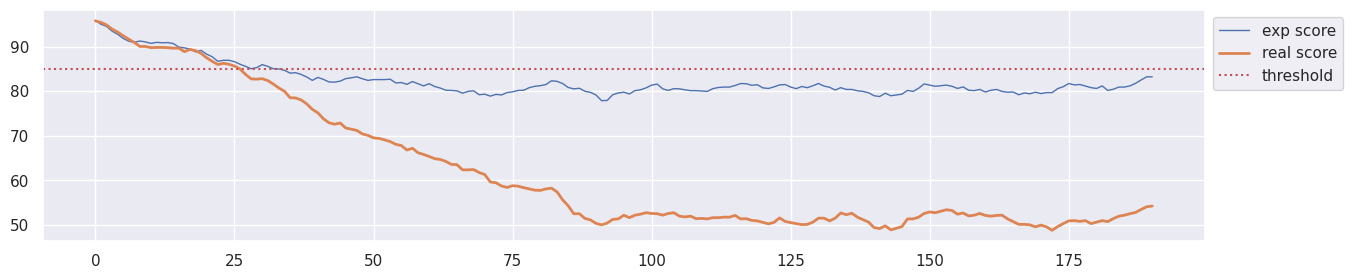

r2 of expected metric vs real metric :-1.62982
Detect at 35 time, uncertainty 0.16111 metric 78.55556


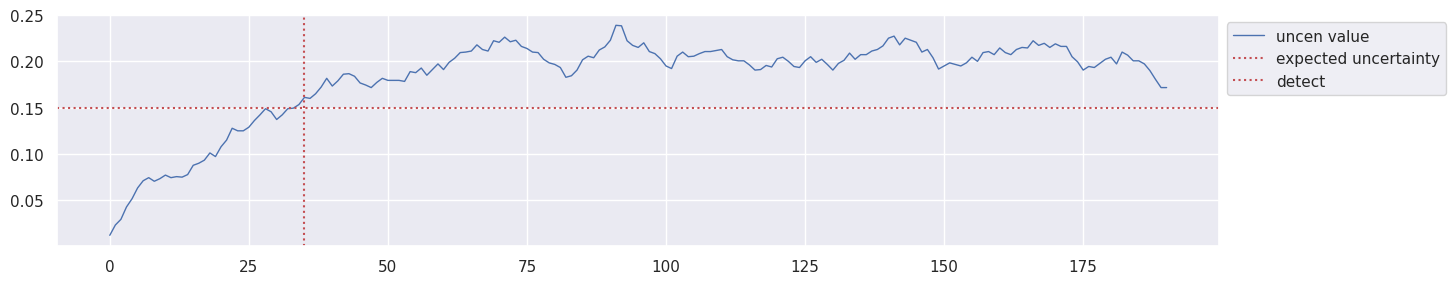

In [178]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #5 Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우

In [179]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

x3    0.145527
x2    0.113997
z0    0.092832
x0    0.043090
x1    0.024980
Name: MI Scores, dtype: float64


In [180]:
X = X4
y = np.asarray(y4)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.31815, Testset metric ['accuracy', 'f1']:[96.77777777777777, 97.27187206020696], Testset uncertainty : 0.00778
random_sigma_add, mean: [-0.01720884  0.0140928  -0.00175924  0.00307308  0.00304705]
random_sigma_add, std: [1.00389506 1.00807954 1.00914251 1.01905838 1.01718532]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:47<00:00,  8.37it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:22<00:00,  8.32it/s]


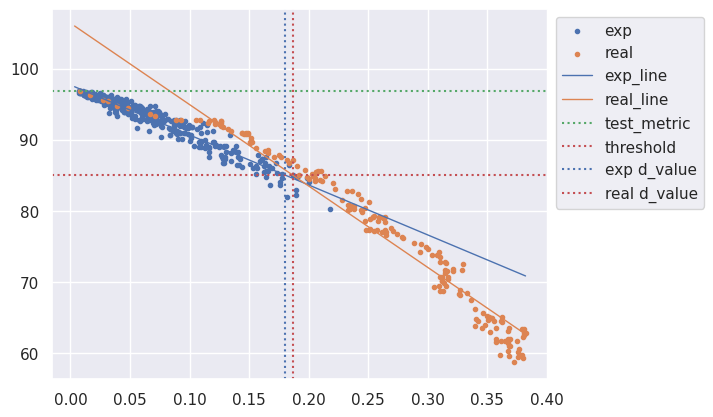

expected_uncertainty @ threshold 85 : 0.18049
    real_uncertainty @ threshold 85 : 0.18677
threshold error : 0.00628


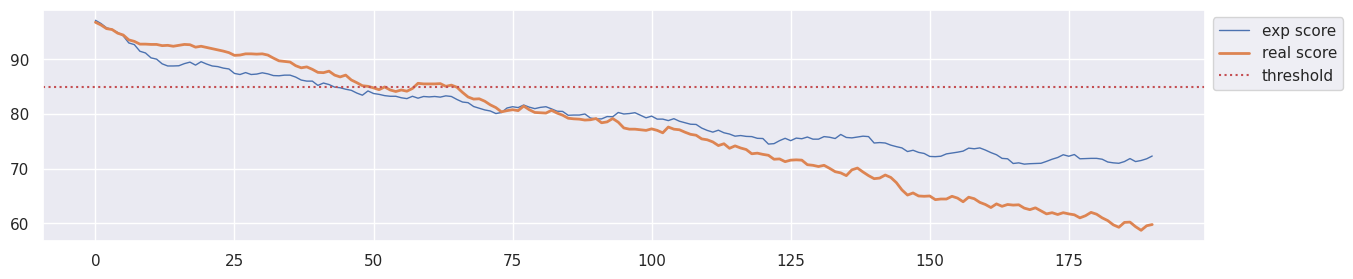

r2 of expected metric vs real metric :0.75285
Detect at 44 time, uncertainty 0.18333 metric 86.77778


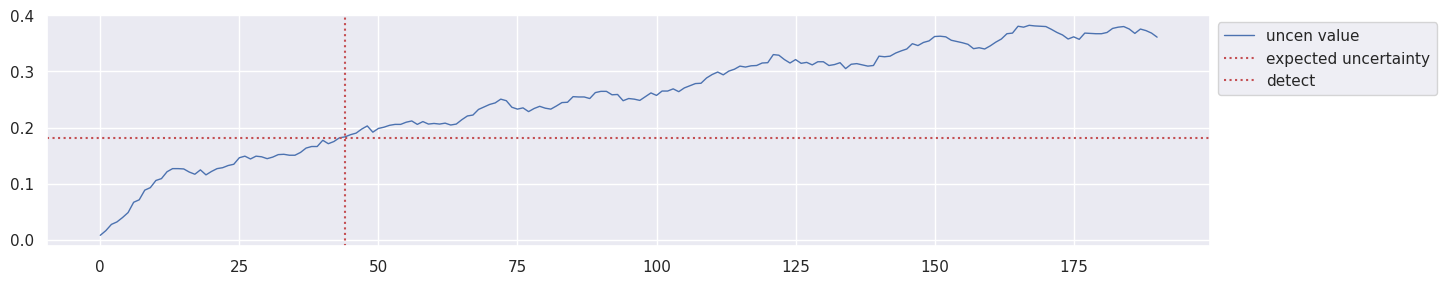

In [181]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Case #6 Case #3,4의 상황이 각 feature에 혼재되어 있는 경우

In [182]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

z0    0.254714
x3    0.067504
x1    0.043212
x0    0.026915
x2    0.001097
Name: MI Scores, dtype: float64


In [183]:
X = X4
y = np.asarray(y4)

Structure of dataset, x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty: (x_train=(1800, 5), x_test=(1800, 5))
Max MI for Trainset 0.32964, Testset metric ['accuracy', 'f1']:[92.72222222222221, 93.92111368909512], Testset uncertainty : 0.00944
random_sigma_add, mean: [-0.01720884  0.00509998 -0.00586527  0.00307308  0.00304705]
random_sigma_add, std: [1.00389506 1.00943785 0.99004917 1.01905838 1.01718532]
Noise set :  (400, 1800, 5)


100%|██████████| 400/400 [00:48<00:00,  8.17it/s]


Truncate 7200 rows from live_set (39800, 5)
Live set :  (191, 1800, 5)


100%|██████████| 191/191 [00:22<00:00,  8.31it/s]


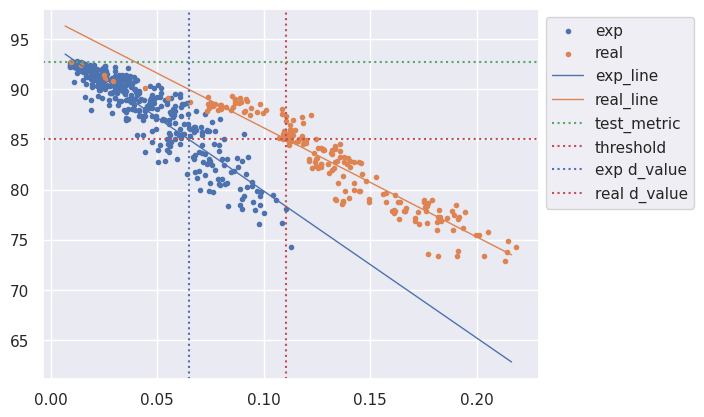

expected_uncertainty @ threshold 85 : 0.06478
    real_uncertainty @ threshold 85 : 0.11054
threshold error : 0.04576


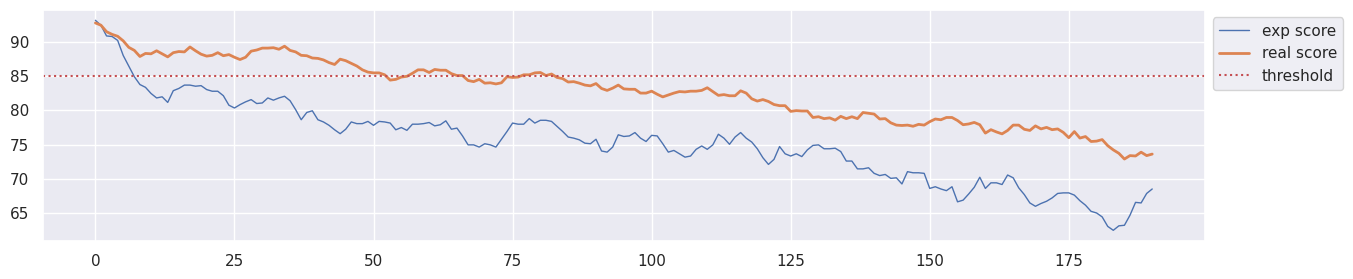

r2 of expected metric vs real metric :-1.84620
Detect at 8 time, uncertainty 0.07333 metric 87.83333


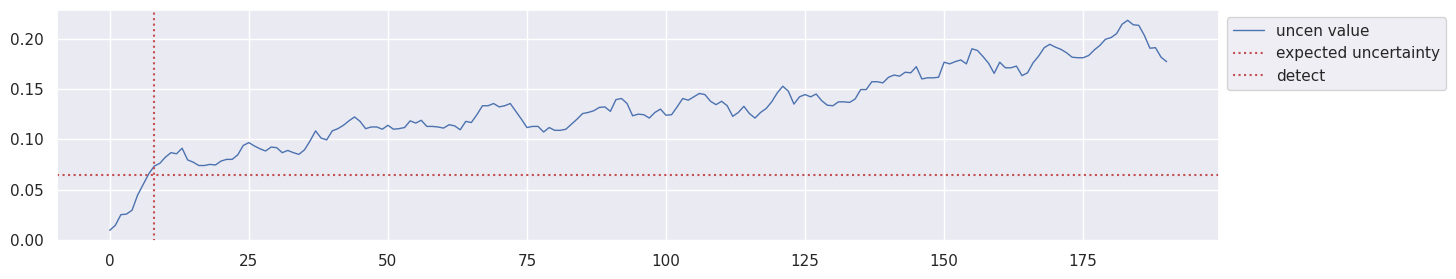

In [184]:
train_size = 1800
test_size = 200

experiment(X,y,train_size,test_size,threshold=85)

## Real-world data(Loan data)의 실험

In [104]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [105]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [106]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [185]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df_accepted.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [186]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [187]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375252
last_fico_range_high    0.091265
last_pymnt_amnt         0.085751
total_rec_late_fee      0.032574
int_rate                0.018439
                          ...   
F4                      0.000000
pub_rec_bankruptcies    0.000000
B2                      0.000000
G4                      0.000000
loan_amnt               0.000000
Name: MI Scores, Length: 81, dtype: float64


### Loan Data 실험

In [188]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

#### 실험 #1 Top 1~5, 4개의 feature 적용

In [189]:
top_columns = list(mi_scores[1:5].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

In [190]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2]

In [191]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


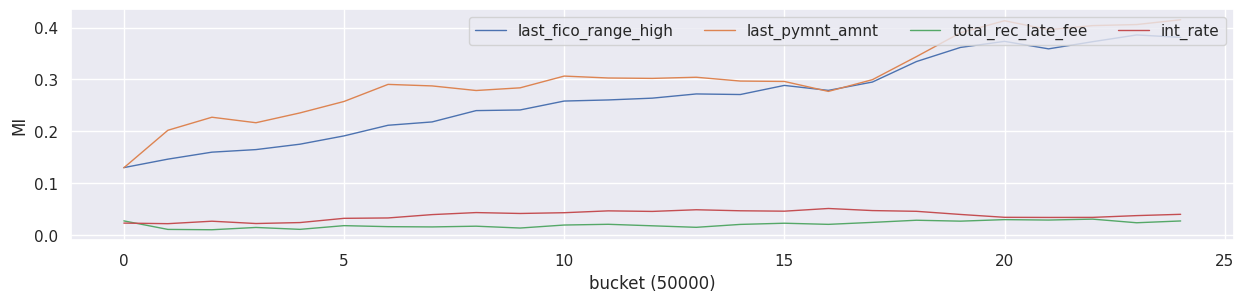

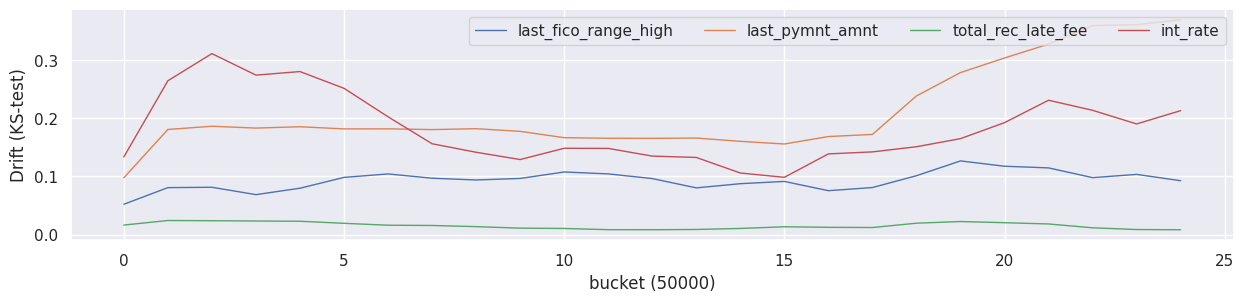

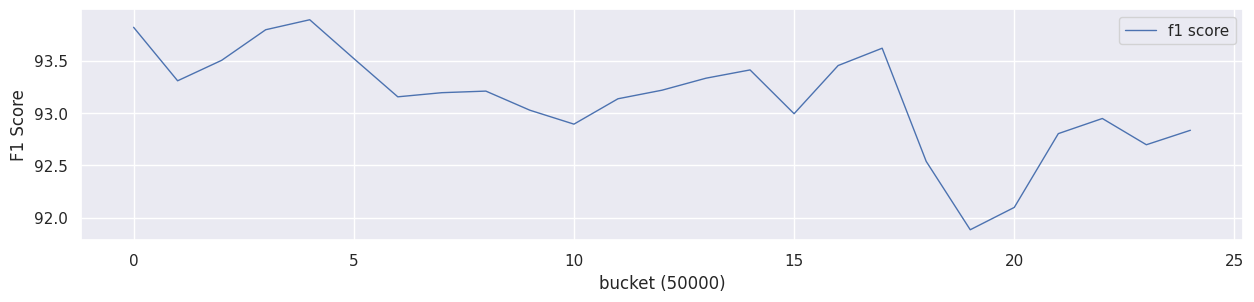

In [192]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

In [193]:
Xr = X2
yr = np.asarray(Y2)

Structure of dataset, x_train: (10000, 4) x_test: (10000, 4) x_live: (1278533, 4)
uncertainty: (x_train=(10000, 4), x_test=(10000, 4))
Max MI for Trainset 0.09105, Testset metric ['accuracy', 'f1']:[90.42999999999999, 94.68185607113088], Testset uncertainty : 0.00680
random_sigma_add, mean: [-0.00666422  0.00734777 -0.00914276 -0.04239751]
random_sigma_add, std: [1.00860832 1.00180582 0.99057276 1.03886658]
Noise set :  (400, 10000, 4)


100%|██████████| 400/400 [02:37<00:00,  2.55it/s]


Truncate 47492 rows from live_set (1278533, 4)
Live set :  (1106, 10000, 4)


100%|██████████| 1106/1106 [07:07<00:00,  2.58it/s]


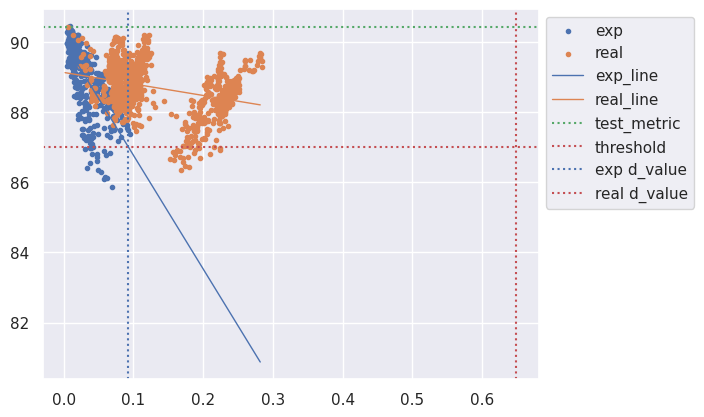

expected_uncertainty @ threshold 87 : 0.09292
    real_uncertainty @ threshold 87 : 0.64835
threshold error : 0.55543


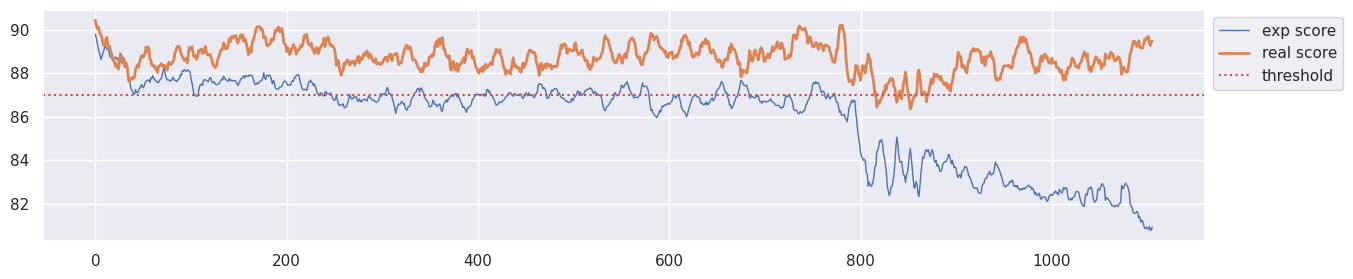

r2 of expected metric vs real metric :-24.80074
Detect at 106 time, uncertainty 0.09490 metric 88.64000


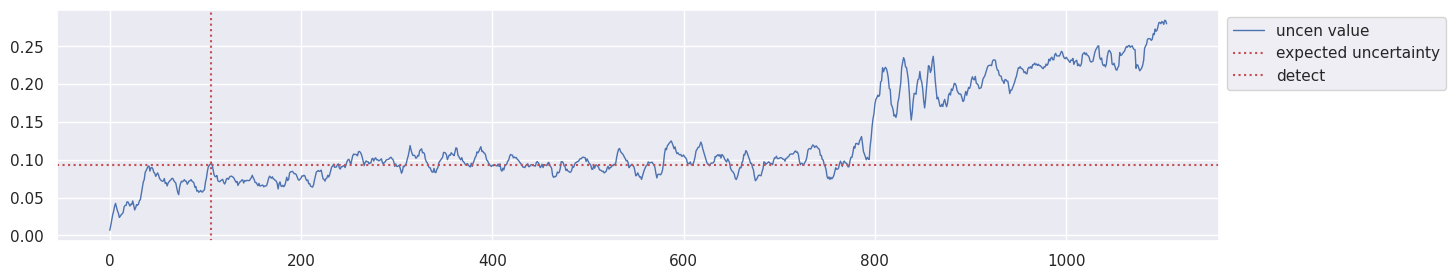

In [194]:
train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=87)

#### 실험 #2 Top 3~5 2개의 feature 사용

In [195]:
top_columns = list(mi_scores[3:5].index)
top_columns

['total_rec_late_fee', 'int_rate']

In [196]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[14, 2]

In [197]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


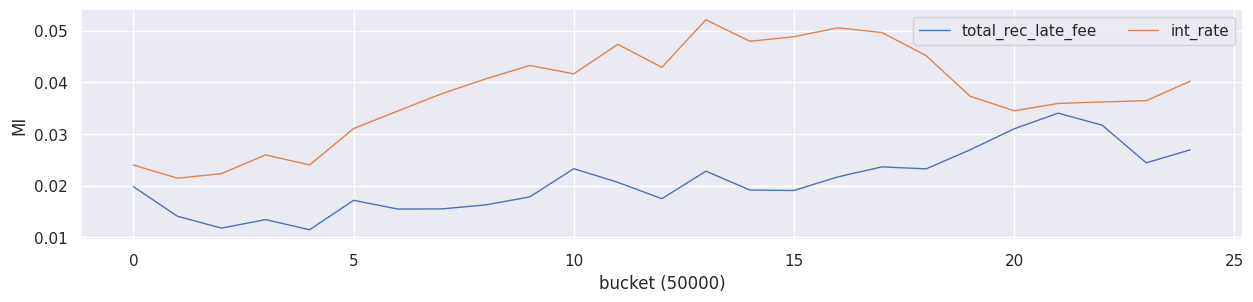

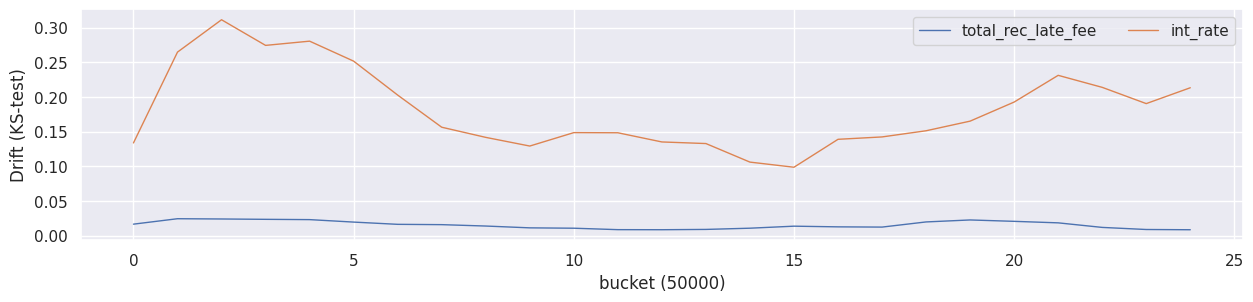

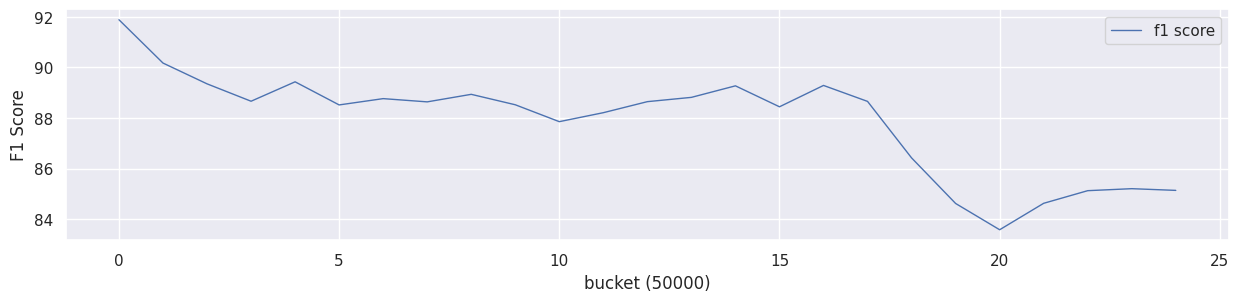

In [198]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 2) x_test: (10000, 2) x_live: (1278533, 2)
uncertainty: (x_train=(10000, 2), x_test=(10000, 2))
Max MI for Trainset 0.03441, Testset metric ['accuracy', 'f1']:[88.3, 93.70222844224352], Testset uncertainty : 0.01760
random_sigma_add, mean: [-0.00914276 -0.04239751]
random_sigma_add, std: [0.99057276 1.03886658]
Noise set :  (400, 10000, 2)


100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


Truncate 47492 rows from live_set (1278533, 2)
Live set :  (1106, 10000, 2)


100%|██████████| 1106/1106 [07:10<00:00,  2.57it/s]


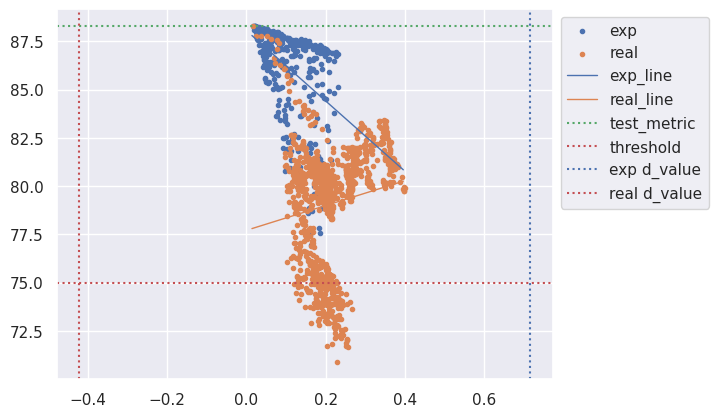

expected_uncertainty @ threshold 75 : 0.71586
    real_uncertainty @ threshold 75 : -0.42106
threshold error : 1.13691


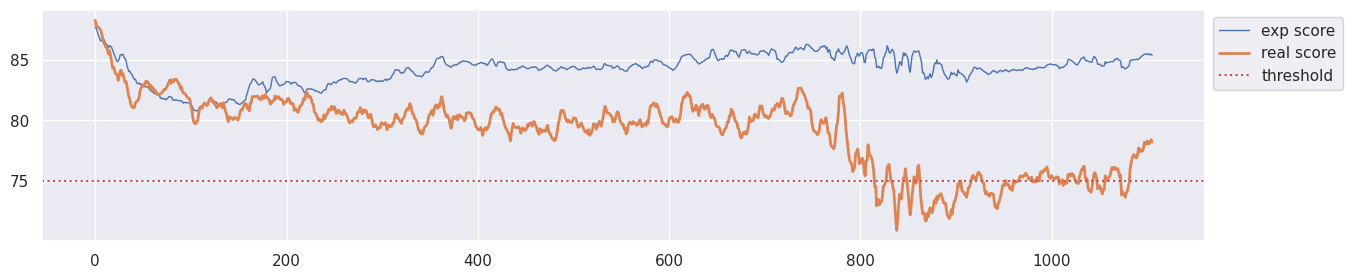

r2 of expected metric vs real metric :-3.21952
Detect fail!!


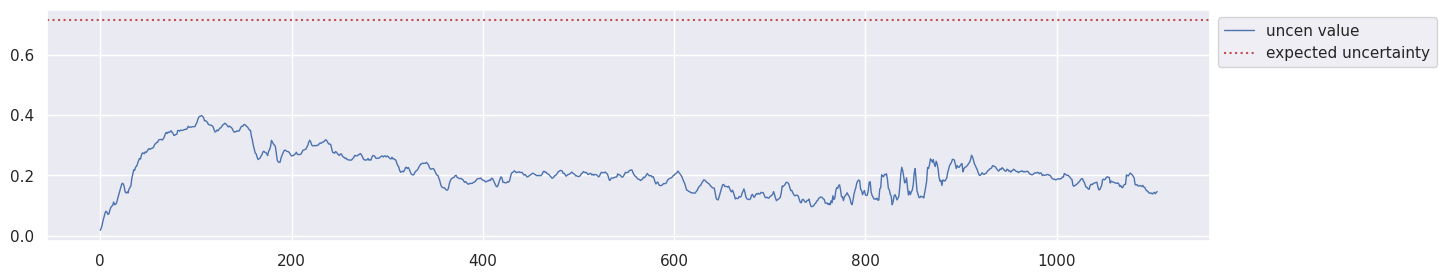

In [199]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147
live_size = 50000
columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=75)

#### 실험 #3 Top 1~3 2개의 feature 사용

In [200]:
top_columns = list(mi_scores[1:3].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt']

In [201]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


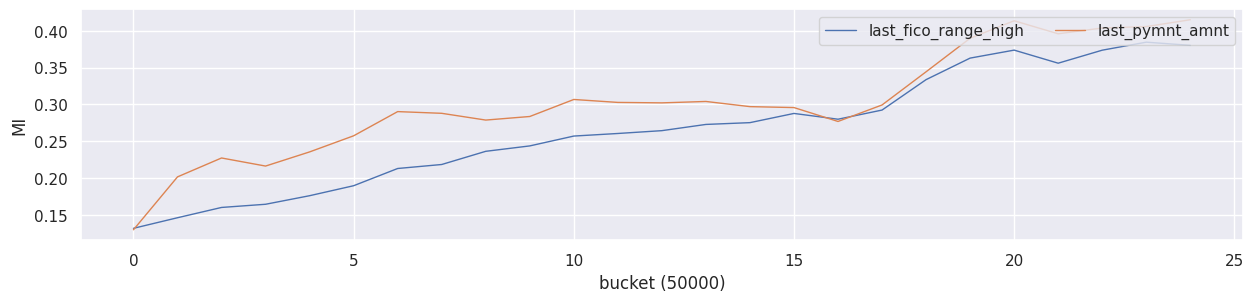

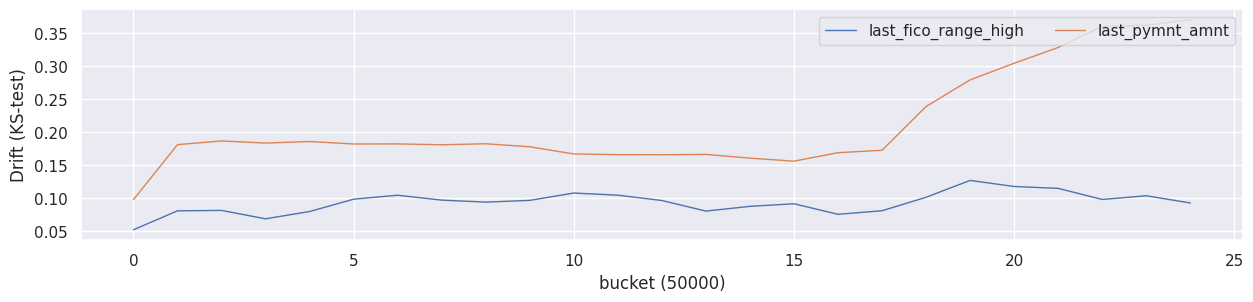

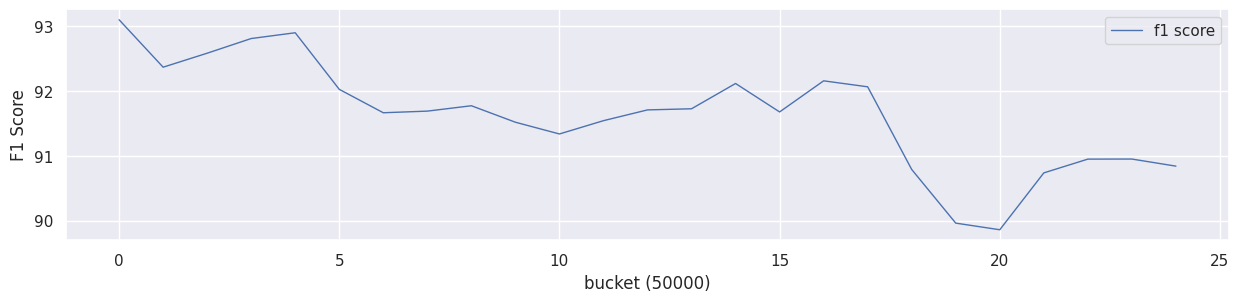

In [202]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 2) x_test: (10000, 2) x_live: (1278533, 2)
uncertainty: (x_train=(10000, 2), x_test=(10000, 2))
Max MI for Trainset 0.08798, Testset metric ['accuracy', 'f1']:[89.25, 94.06438076307217], Testset uncertainty : 0.00620
random_sigma_add, mean: [-0.00666422  0.00734777]
random_sigma_add, std: [1.00860832 1.00180582]
Noise set :  (400, 10000, 2)


100%|██████████| 400/400 [02:39<00:00,  2.51it/s]


Truncate 47492 rows from live_set (1278533, 2)
Live set :  (1106, 10000, 2)


100%|██████████| 1106/1106 [07:15<00:00,  2.54it/s]


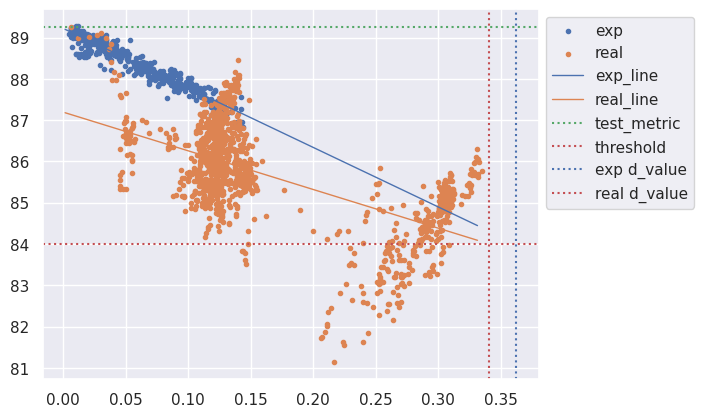

expected_uncertainty @ threshold 84 : 0.36235
    real_uncertainty @ threshold 84 : 0.34094
threshold error : 0.02140


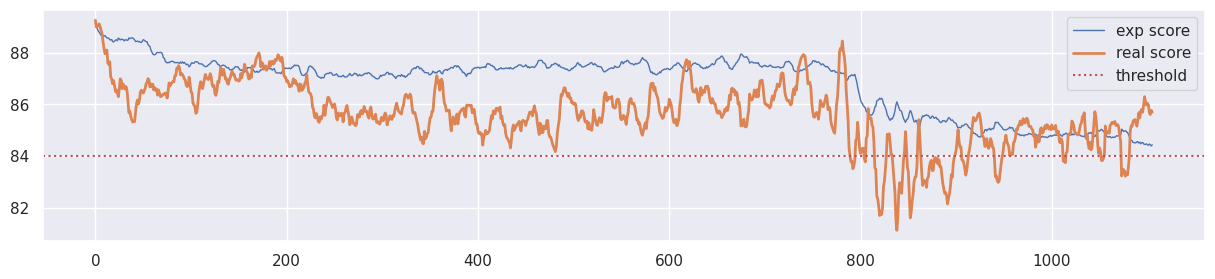

r2 of expected metric vs real metric :-0.69200
Detect fail!!


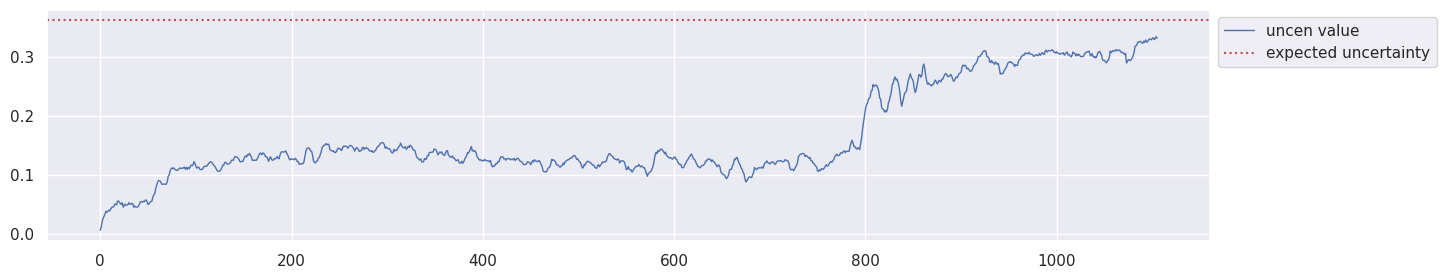

In [203]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=84)

#### 실험 #4 Top 0~10 10개의 feature 사용 --> 사실상 의미 있는 모든 feature 사용

Bucket size 50000 step_size 25


100%|██████████| 25/25 [01:11<00:00,  2.87s/it]


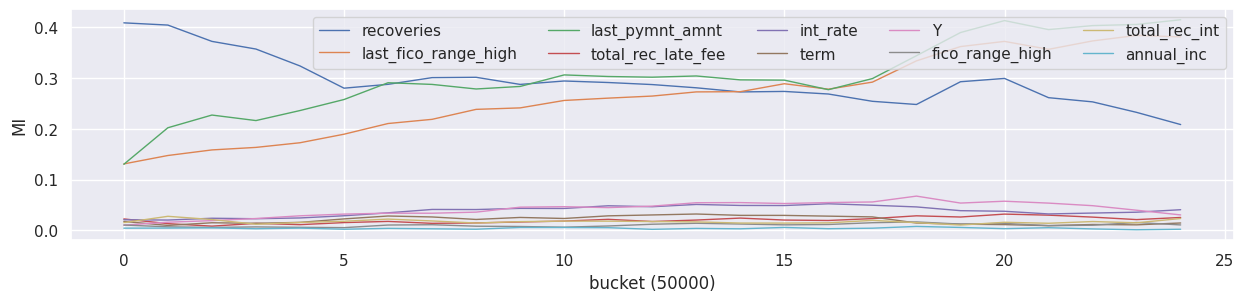

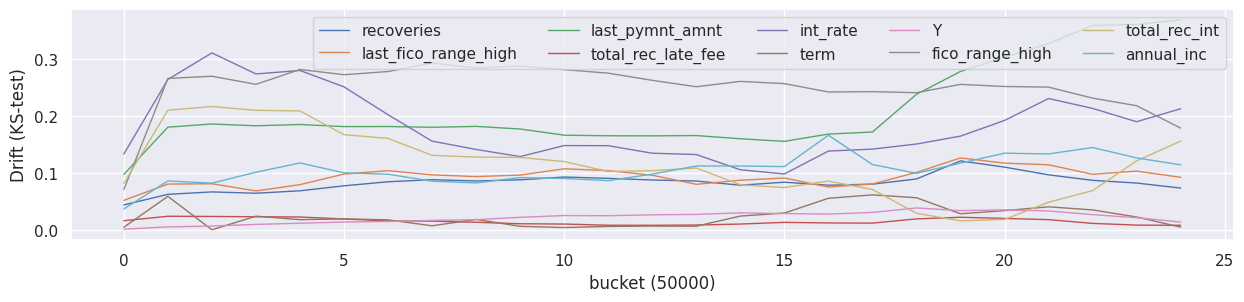

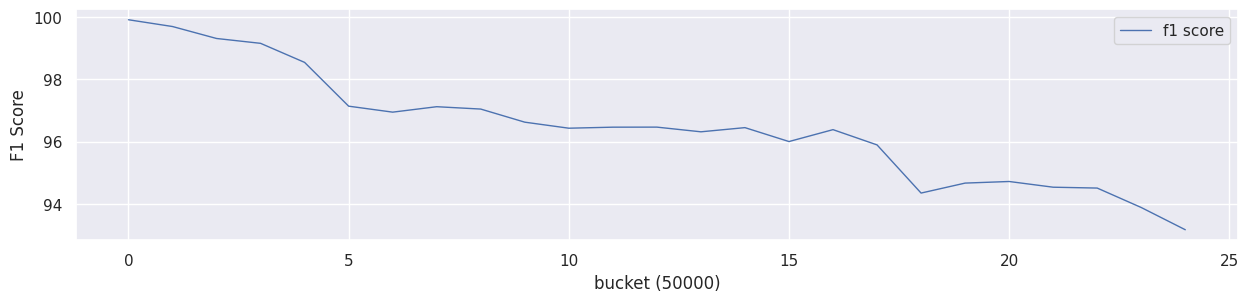

In [204]:
top_columns = list(mi_scores[0:10].index)
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

Structure of dataset, x_train: (10000, 10) x_test: (10000, 10) x_live: (1278533, 10)
uncertainty: (x_train=(10000, 10), x_test=(10000, 10))
Max MI for Trainset 0.37727, Testset metric ['accuracy', 'f1']:[99.96000000000001, 99.97704315886135], Testset uncertainty : 0.00570
random_sigma_add, mean: [-0.00313217 -0.00666422  0.00734777 -0.00914276 -0.04239751  0.09390999
 -0.00633724  0.00320304  0.00496197  0.00259796]
random_sigma_add, std: [0.92811981 1.00860832 1.00180582 0.99057276 1.03886658 1.0474236
 0.94887378 1.00359305 1.03117948 1.02340468]
Noise set :  (400, 10000, 10)


100%|██████████| 400/400 [02:12<00:00,  3.02it/s]


Truncate 47492 rows from live_set (1278533, 10)
Live set :  (1106, 10000, 10)


100%|██████████| 1106/1106 [05:55<00:00,  3.11it/s]


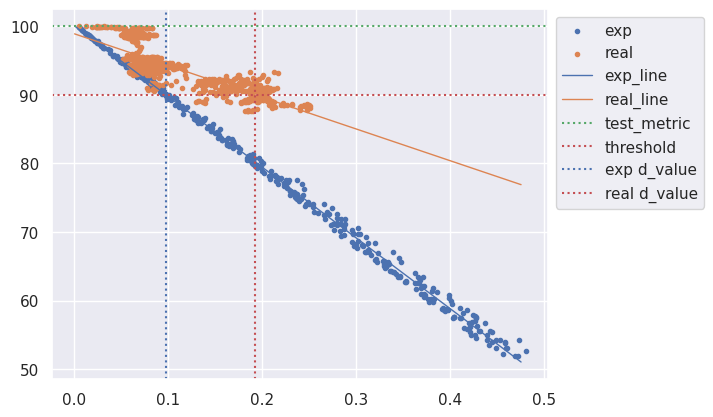

expected_uncertainty @ threshold 90 : 0.09801
    real_uncertainty @ threshold 90 : 0.19269
threshold error : 0.09468


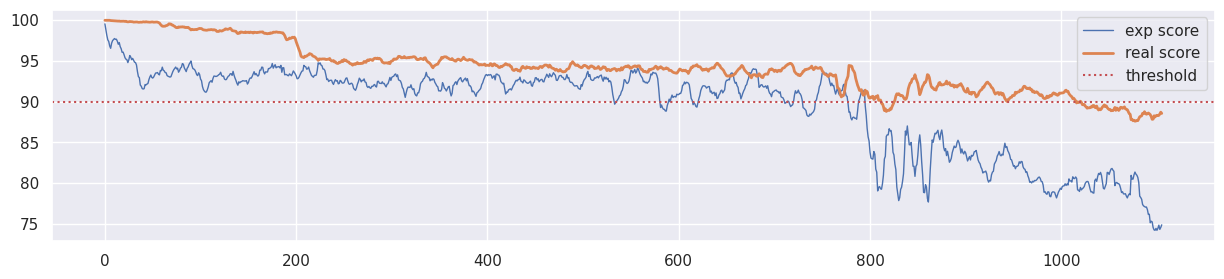

r2 of expected metric vs real metric :-2.87376
Detect at 534 time, uncertainty 0.09940 metric 93.96000


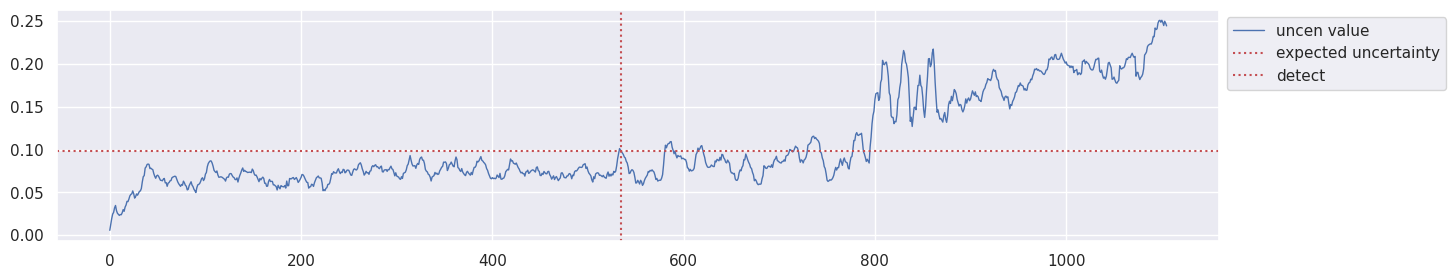

In [205]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147

columns = top_columns
experiment(Xr,yr,train_size,test_size,threshold=90)

# 도운 Dataset 실험

## 00.csv
+ 어떤 특성이 있는지 모름...

In [206]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/00.csv', index_col = 0)
data_00_df

time        C00        C01        C02        C03  D00  D01  \
0       55927.000000  65.965433  26.920842  12.770995  11.376428    8   21   
1       55927.006944  45.741756  36.375457   7.289673  46.325066   13    1   
2       55927.013889  90.143489  30.322969  10.091476  32.730630    8    4   
3       55927.020833  71.483239  15.346720   7.872696  31.377214    9   27   
4       55927.027778  78.145022  30.649774  12.219163  36.575666    8   13   
...              ...        ...        ...        ...        ...  ...  ...   
105259  56657.965278  47.500233   0.120889  15.151155   8.653207    5   16   
105260  56657.972222  44.540096  -0.232403  17.759726  18.393659    8    9   
105261  56657.979167  38.552870   0.210009  12.875184  13.340120   19   11   
105262  56657.986111  33.604683   0.092409  25.840889  22.857934   19   21   
105263  56657.993056  38.506056   0.181421  20.379221  20.741951   13   16   

        D02  D03  y  drift  
0        21    7  1    0.0  
1        20    6  1    0.0  
2        22    0  1    0.0  
3        21    4  1    0.0  
4        20    3  1    0.0  
...     ...  ... ..    ...  
105259    3   11  0    1.0  
105260   21    7  1    1.0  
105261    4   11  0    1.0  
105262    4   11  0    1.0  
105263    3    6  0    1.0  

[105264 rows x 11 columns]

In [207]:
data_00_df.drop(columns=['time','drift'],inplace=True)

In [208]:
data_00_df.shape

(105264, 9)

Bucket size 1000 step_size 100


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


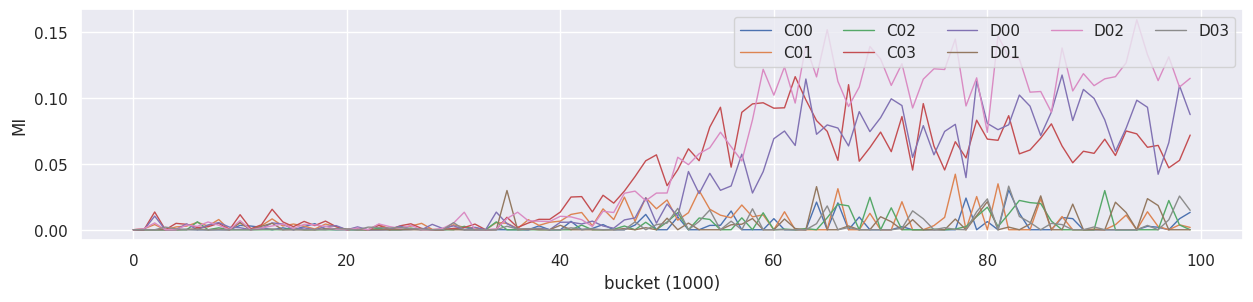

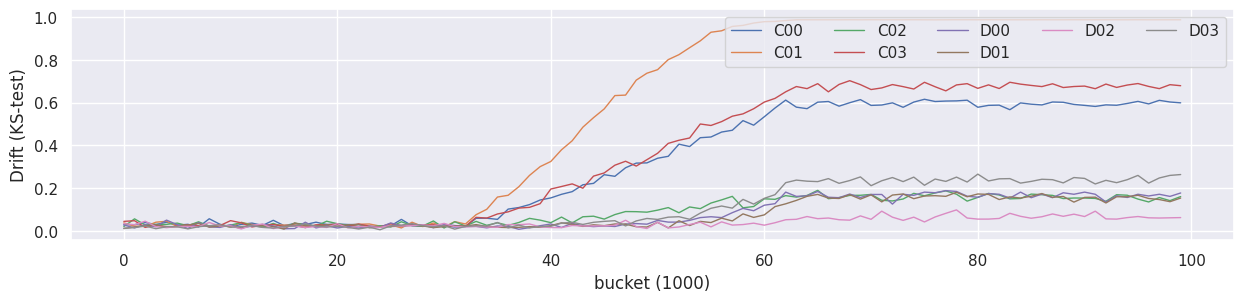

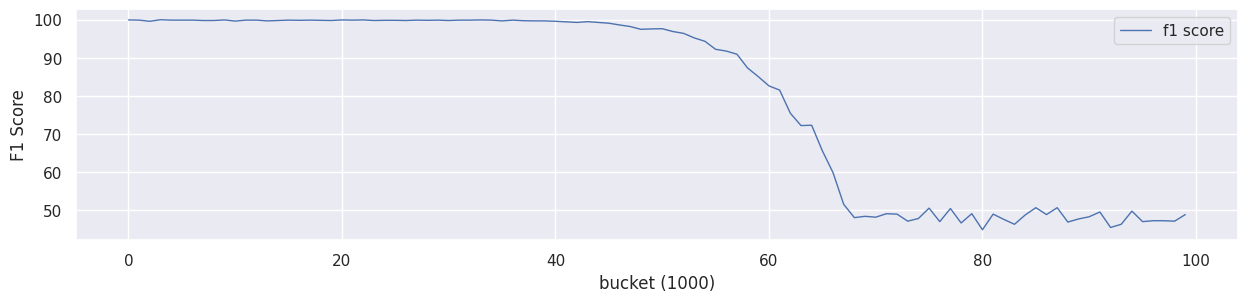

In [209]:
X2 = data_00_df[['C00','C01','C02','C03','D00','D01','D02','D03']]
Y2 = data_00_df['y']

model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = ['C00','C01','C02','C03','D00','D01','D02','D03']
MI_Drift_F1(model, X2,Y2,4500,500,1000)

Structure of dataset, x_train: (4500, 8) x_test: (4500, 8) x_live: (104764, 8)
uncertainty: (x_train=(4500, 8), x_test=(4500, 8))
Max MI for Trainset 0.00376, Testset metric ['accuracy', 'f1']:[99.8, 99.89983305509182], Testset uncertainty : 0.00556
random_sigma_add, mean: [ 0.00349732 -0.00202195  0.00077711  0.00070785  0.00662708  0.00516288
  0.0041442  -0.00185264]
random_sigma_add, std: [1.00263814 1.00312428 1.0157597  0.98742625 0.99690525 1.00449496
 0.9990135  0.99625088]
Noise set :  (400, 4500, 8)


100%|██████████| 400/400 [01:07<00:00,  5.91it/s]


Truncate 20112 rows from live_set (104764, 8)
Live set :  (201, 4500, 8)


100%|██████████| 201/201 [00:35<00:00,  5.70it/s]


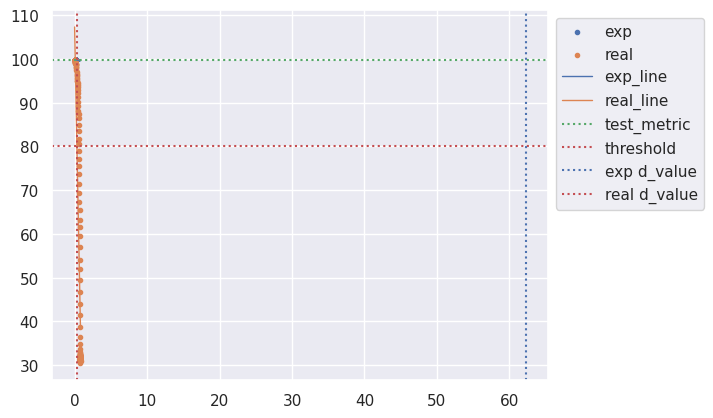

expected_uncertainty @ threshold 80 : 62.22120
    real_uncertainty @ threshold 80 : 0.31669
threshold error : 61.90452


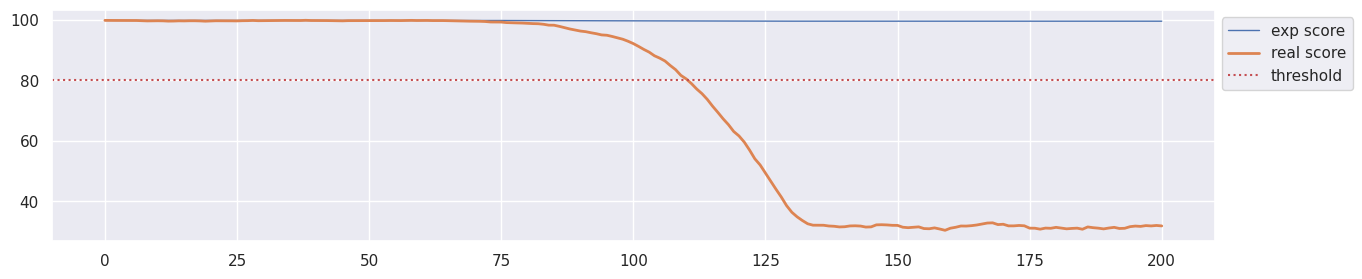

r2 of expected metric vs real metric :-0.84008
Detect fail!!


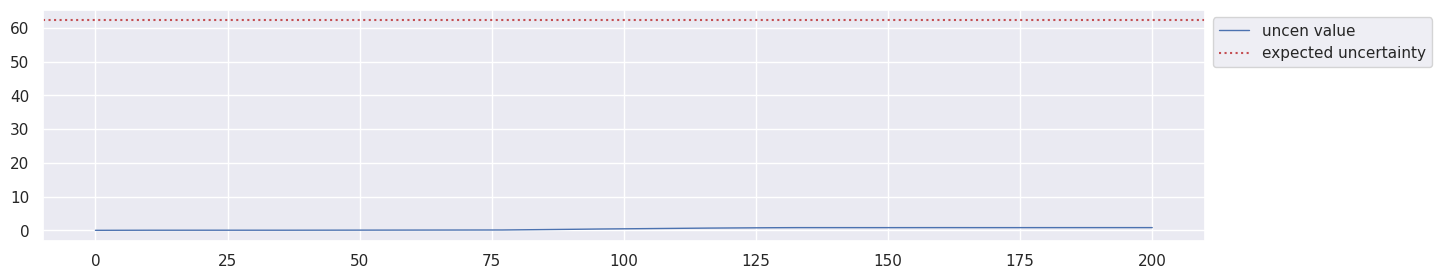

In [210]:
train_size = 4500
test_size = 500

experiment(X2.values,Y2.values,train_size,test_size,threshold=80)

## sine_0123_gradual

In [211]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/sine_0123_gradual.csv')
data_00_df

X1        X2  class
0      0.017490  0.891573    1.0
1      0.792034  0.324471    0.0
2      0.112312  0.141897    1.0
3      0.132102  0.037110    0.0
4      0.081988  0.213440    1.0
...         ...       ...    ...
40995  0.899356  0.539090    1.0
40996  0.269991  0.151515    0.0
40997  0.842951  0.876155    1.0
40998  0.541211  0.315449    0.0
40999  0.901501  0.690306    1.0

[41000 rows x 3 columns]

Bucket size 400 step_size 91


100%|██████████| 91/91 [00:02<00:00, 34.86it/s]


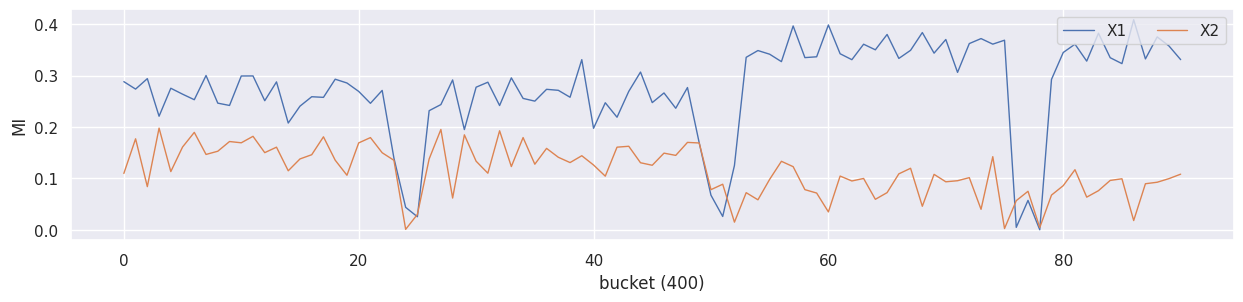

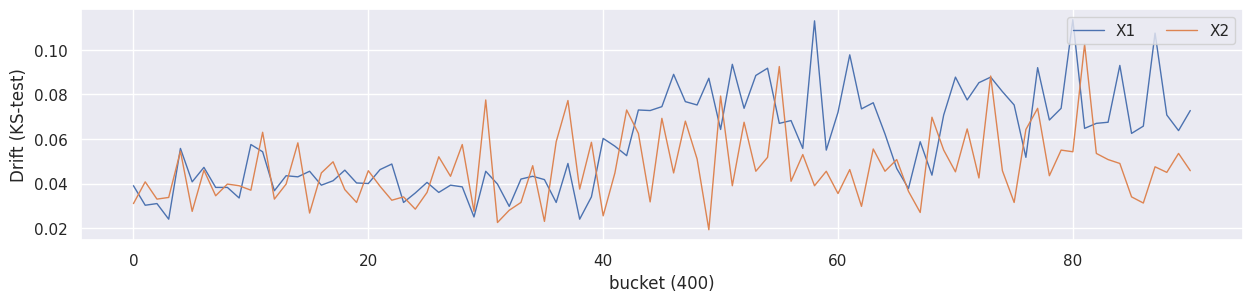

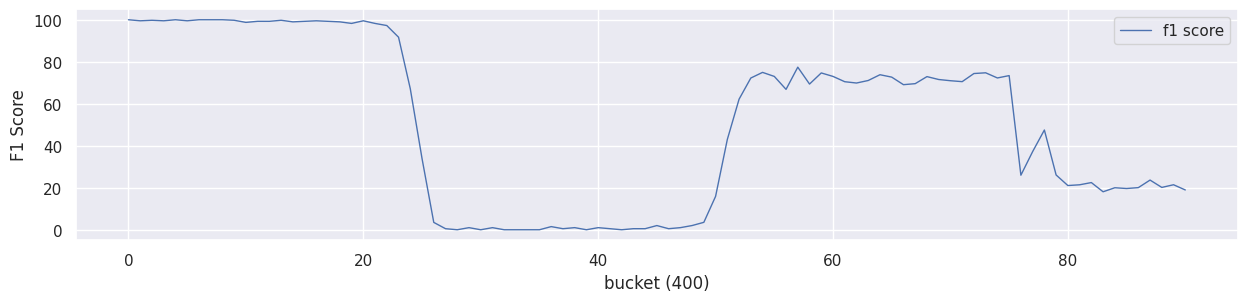

In [212]:
X2 = data_00_df[['X1','X2']]
Y2 = data_00_df['class']
model = RandomForestClassifier(max_depth=6).fit(X2[0:4000].values, Y2[0:4000])

columns = ['X1','X2']
MI_Drift_F1(model, X2,Y2,4000,400,400)

Structure of dataset, x_train: (4000, 2) x_test: (4000, 2) x_live: (40600, 2)
uncertainty: (x_train=(4000, 2), x_test=(4000, 2))
Max MI for Trainset 0.25560, Testset metric ['accuracy', 'f1']:[99.625, 99.625468164794], Testset uncertainty : 0.00500
random_sigma_add, mean: [-0.00017344 -0.00414639]
random_sigma_add, std: [1.00370089 0.99926328]
Noise set :  (400, 4000, 2)


100%|██████████| 400/400 [01:16<00:00,  5.24it/s]


Truncate 19800 rows from live_set (40600, 2)
Live set :  (92, 4000, 2)


100%|██████████| 92/92 [00:17<00:00,  5.37it/s]


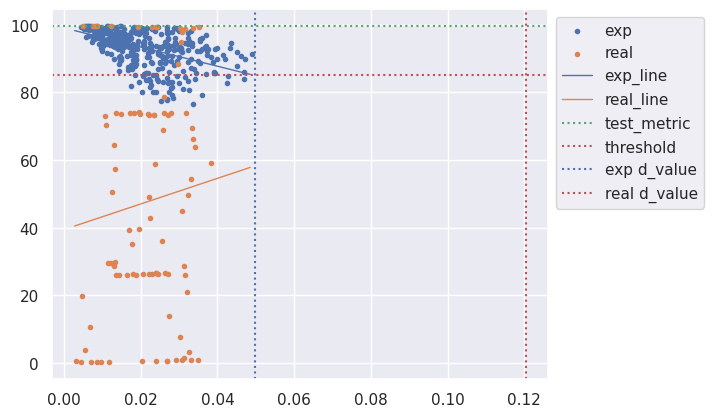

expected_uncertainty @ threshold 85 : 0.04972
    real_uncertainty @ threshold 85 : 0.12031
threshold error : 0.07059


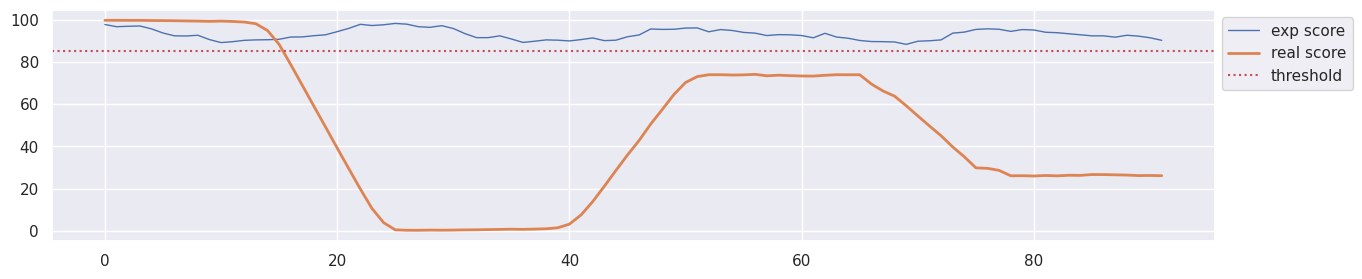

r2 of expected metric vs real metric :-1.80210
Detect fail!!


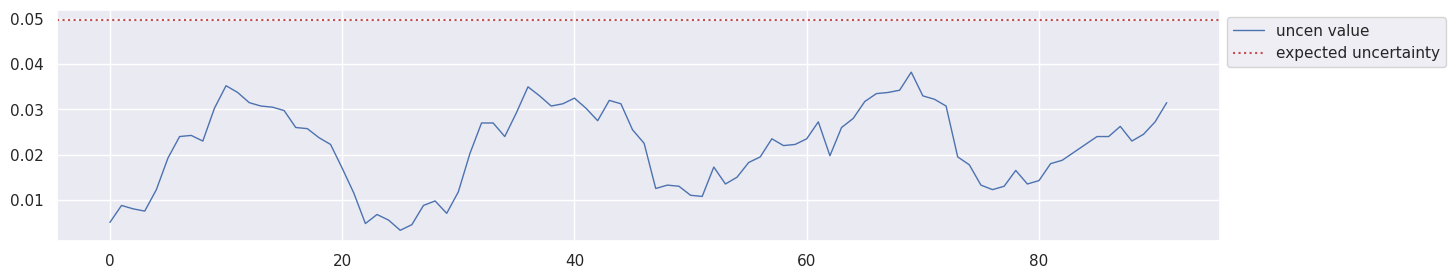

In [213]:
train_size = 4000
test_size = 400

experiment(X2.values,Y2.values,train_size,test_size,threshold=85)

## mixed_0101_gradual.csv

In [214]:
data_00_df = pd.read_csv('/content/drive/MyDrive/Drift/dw/mixed_0101_gradual.csv')
data_00_df

X1   X2        X3        X4  class
0      0.0  1.0  0.460101  0.592744    1.0
1      1.0  1.0  0.588788  0.574984    0.0
2      0.0  0.0  0.401641  0.679325    1.0
3      1.0  1.0  0.306076  0.182108    0.0
4      0.0  0.0  0.962847  0.579245    1.0
...    ...  ...       ...       ...    ...
40995  0.0  1.0  0.802194  0.308799    1.0
40996  0.0  0.0  0.509831  0.060636    0.0
40997  0.0  1.0  0.430608  0.025524    1.0
40998  0.0  0.0  0.867294  0.044091    0.0
40999  1.0  1.0  0.670322  0.221267    1.0

[41000 rows x 5 columns]

Bucket size 400 step_size 91


100%|██████████| 91/91 [00:03<00:00, 28.52it/s]


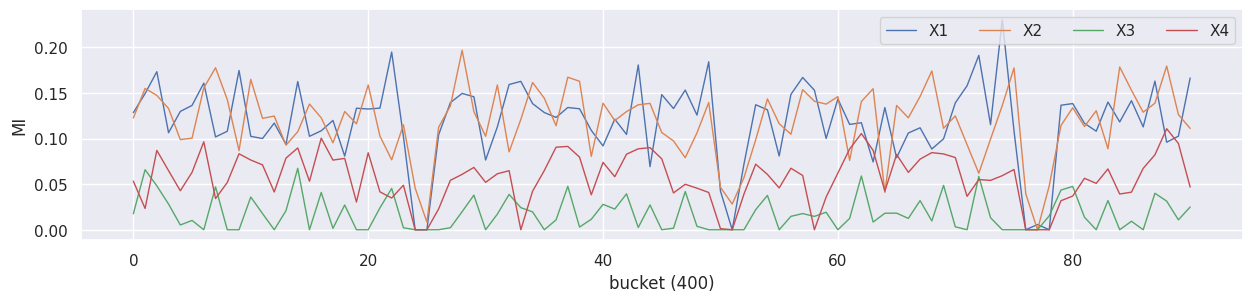

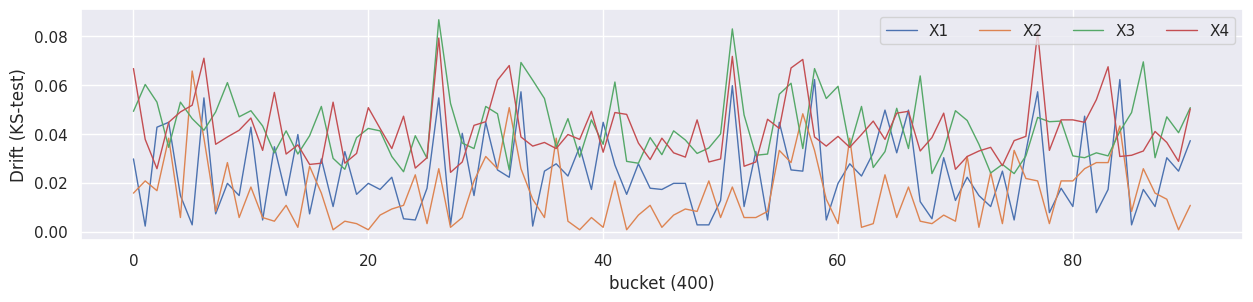

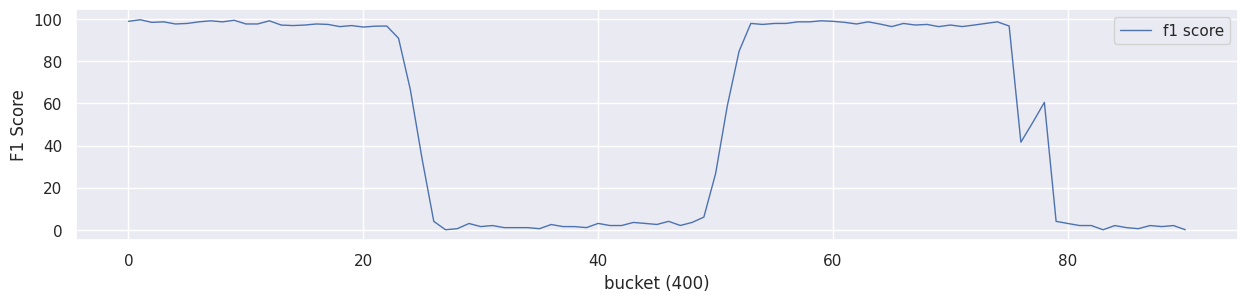

In [215]:
X2 = data_00_df[['X1','X2','X3','X4']]
Y2 = data_00_df['class']
model = RandomForestClassifier(max_depth=6).fit(X2[0:4000].values, Y2[0:4000])

columns = ['X1','X2','X3','X4']
MI_Drift_F1(model, X2,Y2,4000,400,400)

Structure of dataset, x_train: (4000, 4) x_test: (4000, 4) x_live: (40600, 4)
uncertainty: (x_train=(4000, 4), x_test=(4000, 4))
Max MI for Trainset 0.13960, Testset metric ['accuracy', 'f1']:[98.5, 98.50224663005493], Testset uncertainty : 0.00525
random_sigma_add, mean: [-0.00200024  0.00951262  0.00422856  0.00195226]
random_sigma_add, std: [0.99996699 1.00044521 0.99596294 1.00068142]
Noise set :  (400, 4000, 4)


100%|██████████| 400/400 [01:18<00:00,  5.07it/s]


Truncate 19800 rows from live_set (40600, 4)
Live set :  (92, 4000, 4)


100%|██████████| 92/92 [00:17<00:00,  5.30it/s]


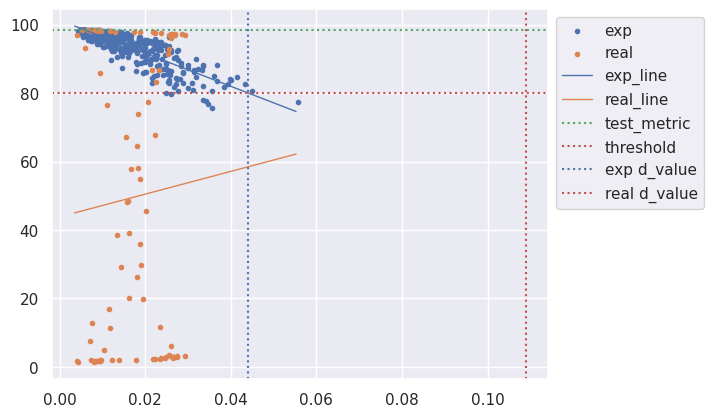

expected_uncertainty @ threshold 80 : 0.04408
    real_uncertainty @ threshold 80 : 0.10887
threshold error : 0.06479


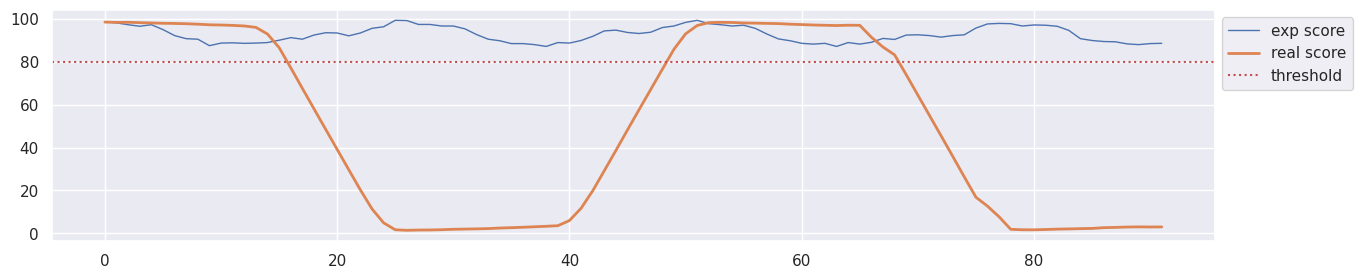

r2 of expected metric vs real metric :-1.08914
Detect fail!!


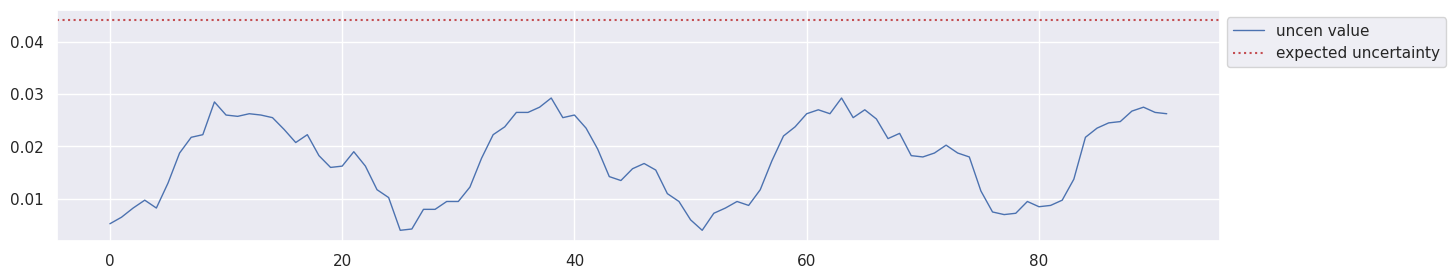

In [216]:
train_size = 4000
test_size = 400

experiment(X2.values,Y2.values,train_size,test_size,threshold=80)